In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler 
from ISLP import load_data
from functools import partial
from sklearn.model_selection import train_test_split
from ISLP.models import (ModelSpec as MS,
summarize , poly)

from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression 
from ISLP.models import (Stepwise , sklearn_selected , sklearn_selection_path)

import itertools
import statsmodels.api as sm
from l0bnb import fit_path
import time

In [144]:
# Importing the dataset
dataset = pd.read_csv('Faellesdata.csv')
dataset.head()

,rsph,x,y,z,vx,vy,vz,Rcyl,phi,vRcyl,...,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
0,1.287,1.170,-0.397,0.361,-24.502,183.760,-92.909,1.236,341.267,-82.221,...,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279,False,0
1,1.534,0.778,-1.312,-0.162,242.744,94.489,24.089,1.525,300.646,42.443,...,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225,False,0
2,6.934,-6.615,2.047,-0.369,-2.347,-296.471,-21.360,6.925,162.806,-85.396,...,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238,True,1
3,5.841,5.832,0.031,-0.330,174.520,129.062,-26.248,5.832,0.303,175.200,...,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222,False,0
4,0.380,0.284,0.070,-0.243,284.772,41.610,304.173,0.292,13.944,286.408,...,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306,False,0


In [145]:
DataFinal = dataset.drop([
        'rsph', 'x', 'y', 'vx', 'vy', 'rsph_form', 'x_form', 
        'y_form', 'z_form', 'vx_form', 'vy_form',
        'vz_form', 'Rcyl_form', 'phi_form', 'vRcyl_form', 'vphi_form'
       ], axis = 1)
DataFinal.head()

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
0,0.361,-92.909,1.236,341.267,-82.221,166.156,6.961,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279,False,0
1,-0.162,24.089,1.525,300.646,42.443,257.005,1.891,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225,False,0
2,-0.369,-21.360,6.925,162.806,-85.396,283.916,0.963,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238,True,1
3,-0.330,-26.248,5.832,0.303,175.200,128.138,1.231,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222,False,0
4,-0.243,304.173,0.292,13.944,286.408,-28.238,8.985,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306,False,0


In [146]:
# Splitting the dataset into the Training set and Test set
all_predictors = ['z', 'vz', 'Rcyl', 'phi', 'vRcyl', 'vphi', 'age', 'mass', 'feh', 'oh', 'ch', 'mgh', 'ofe', 'cfe', 'mgfe']

#random state used to get the same split everytime i run code
X_train, X_test, y_train, y_test = train_test_split(DataFinal[all_predictors], DataFinal['IsMigratorInt'], test_size = 0.2, random_state = 10)

Look for outliers

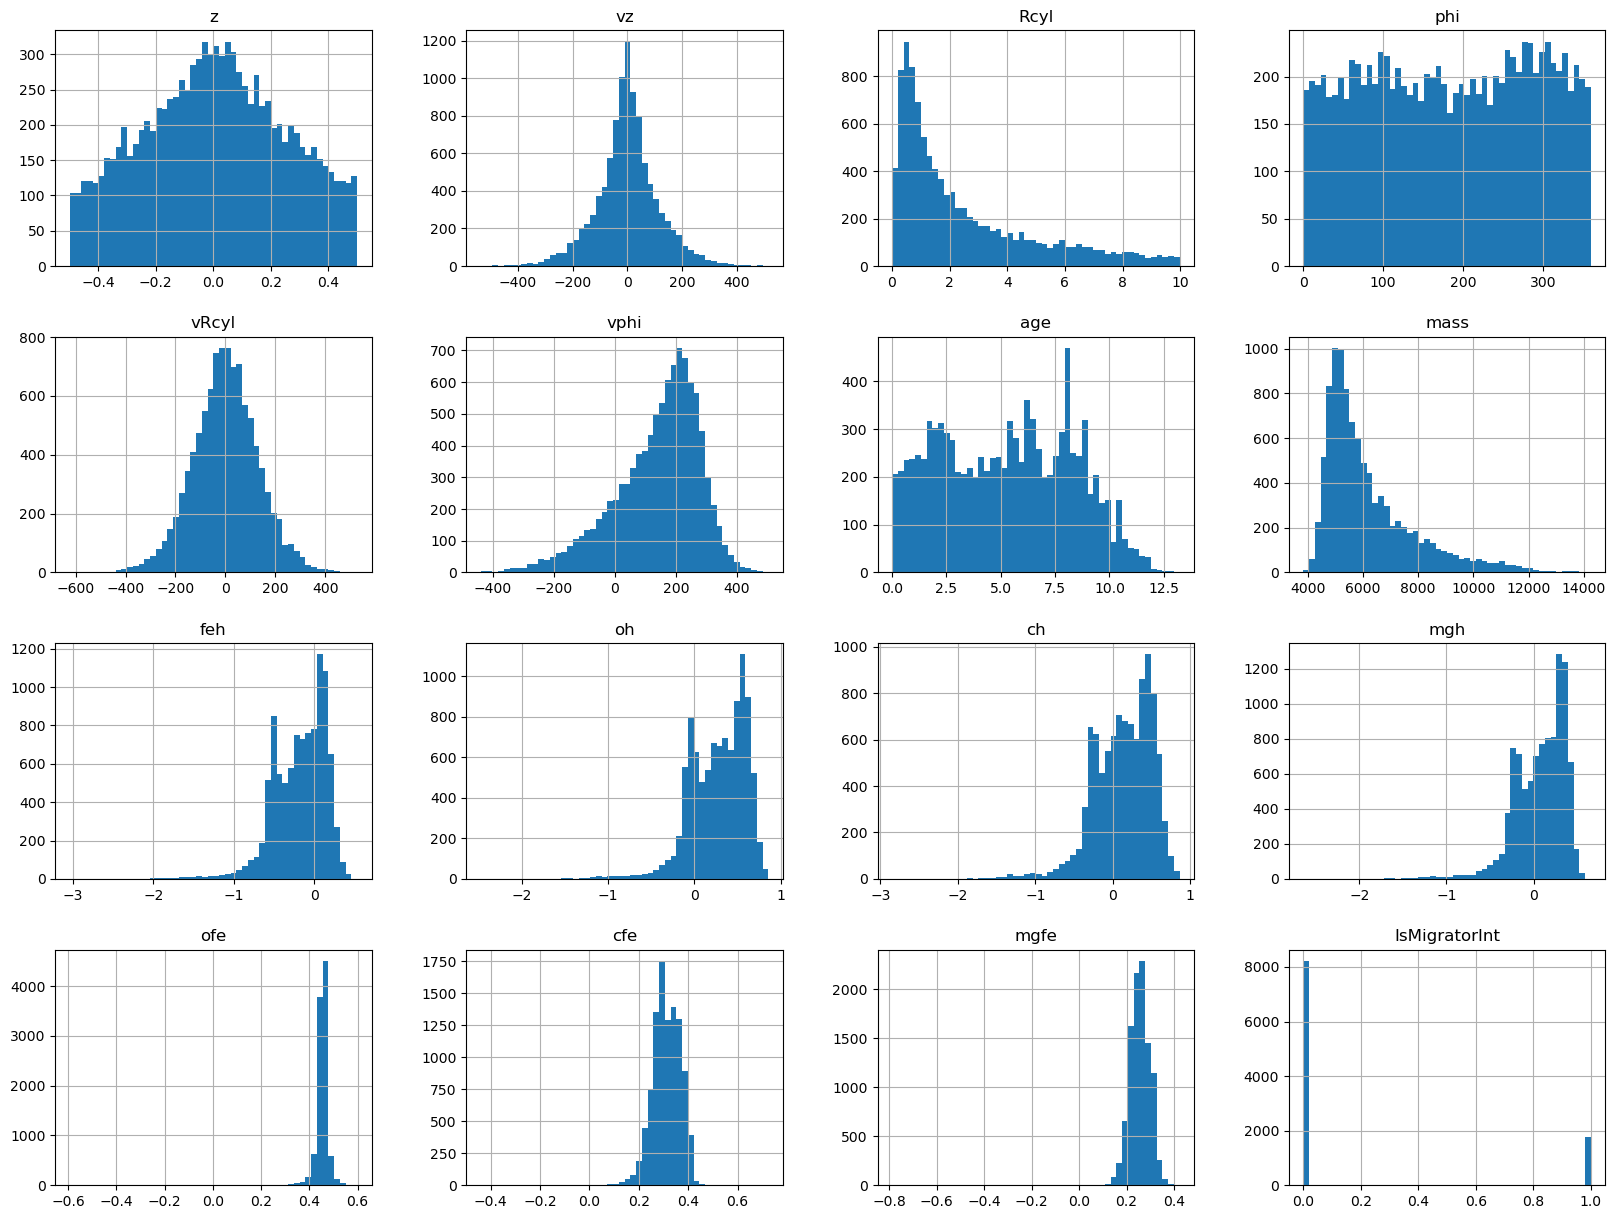

In [147]:
#make histogram of each column 
DataFinal.hist(bins=50, figsize=(20,15));

Percentage of migrator stars in the fina data

In [148]:
DataFinal['IsMigratorInt'].sum()/len(DataFinal['IsMigratorInt'])

0.1775

In [149]:
# Look at the datapoints that has 'ofe' less than 0.2 as they might be outliers
potential_outliers_ofe = DataFinal[DataFinal['ofe'] < 0.2]
potential_outliers_ofe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
1960,0.035,286.296,0.592,296.040,19.960,-95.910,8.009,5001.054,-0.287,-0.122,-0.207,-0.281,0.164,0.080,0.005,False,0
3421,-0.238,-69.483,1.004,348.886,-121.254,-212.352,8.787,4345.667,-0.260,-0.098,-0.194,-0.256,0.163,0.066,0.005,False,0
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.690,-0.582,-1.176,-1.022,-1.371,-0.594,-0.440,-0.788,True,1
9819,-0.495,29.876,5.262,219.212,-322.773,81.001,5.422,8064.787,0.530,0.667,0.539,0.475,0.137,0.009,-0.055,True,1


So we see that it is actually only a single one of these that have a very different value (datapoint 4526) which has -0.594. <br>
Now looking at mgfe we see

In [150]:
potential_outliers_mgfe = DataFinal[DataFinal['mgfe'] < 0.0]
potential_outliers_mgfe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.690,-0.582,-1.176,-1.022,-1.371,-0.594,-0.440,-0.788,True,1
9819,-0.495,29.876,5.262,219.212,-322.773,81.001,5.422,8064.787,0.530,0.667,0.539,0.475,0.137,0.009,-0.055,True,1


Once again it is only datapoint 4526 that has a very small mgfe value. This makes sense since they are all related to the iron

In [151]:
potential_outliers_cfe = DataFinal[DataFinal['cfe'] < -0.1]
potential_outliers_cfe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.69,-0.582,-1.176,-1.022,-1.371,-0.594,-0.44,-0.788,True,1


In [152]:
potential_outliers_oh = DataFinal[DataFinal['oh'] < -1.5]
#potential_outliers_oh

In [153]:
potential_outliers_mgh = DataFinal[DataFinal['mgh'] < -1.5]
#potential_outliers_mgh

We try and drop this 4526 and do the historgrams again. 

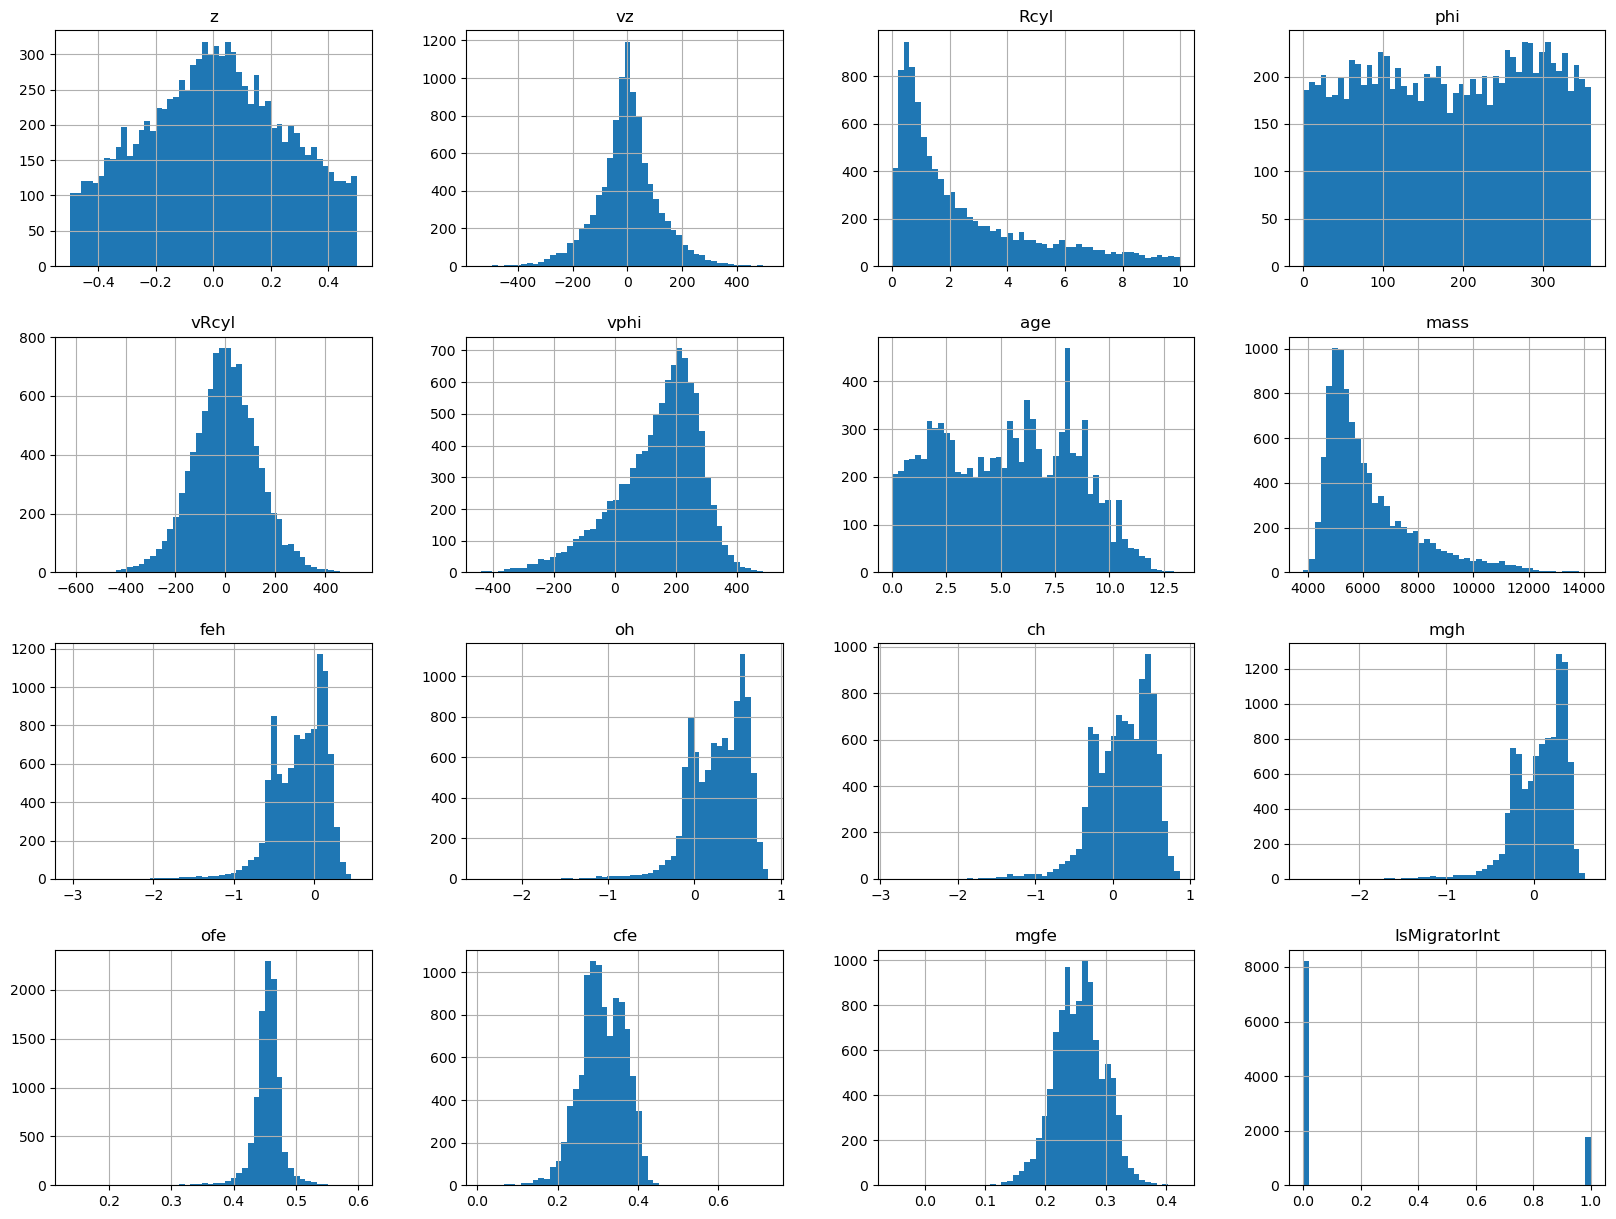

In [154]:
#Drop row 4526 as it is an outlier
DataFinal = DataFinal.drop([4526])
#Save as new csv file where we drop the 'IsMigratorBool' column and have removed the outlier
#Drop the column 
DataFinal = DataFinal.drop(['IsMigratorBool'], axis = 1)
DataFinal.to_csv('Faellesdata_cleaned.csv', index = False)

DataFinal.hist(bins=50, figsize=(20,15));

### Best subset selection

In [155]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X = MS(list(feature_set)).fit_transform(DataFinal[list(feature_set)])
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    TErate = np.mean((regr.predict(X) >= 0.5) != DataFinal['IsMigratorInt'])
    return {"model": regr, "TErate": TErate}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-2], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['TErate'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [156]:
#NO NEED TO RUN RIGHT NOW: ALREADY RAN IN CHRISTIAN'S CODE

# models_best = pd.DataFrame(columns=["TErate", "model"])

# tic = time.time()
# for i in range(len(DataFinal.iloc[:,:-2].columns) + 1):
#     models_best.loc[i] = getBest(i)
 
# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

### Forward selection 

### Backwards selection

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree , export_text)
from sklearn.metrics import (accuracy_score , log_loss) 
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

# Pruning a tree

In [8]:
Df = pd.read_csv('Faellesdata_cleaned.csv')

In [9]:
X_temp = Df.drop('IsMigratorInt', axis = 1)
model = MS(Df.columns.drop('IsMigratorInt'), intercept=False)
D = model.fit_transform(X_temp)
feature_names = list(D.columns)
X = np.asarray(D)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Df['IsMigratorInt'], test_size = 0.2, random_state = 42)

Fit the tree on the training data

In [161]:
clf = DTC(criterion='entropy', random_state=0) 
clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

0.8135

Now we prune the tree to the optimal length. 

In [162]:
ccp_path = clf.cost_complexity_pruning_path(x_train, y_train) 

ccp_alphas = ccp_path.ccp_alphas
reduced_ccp_alphas = np.linspace(min(ccp_alphas), max(ccp_alphas), num=20)  # Select 20 equally spaced values

kfold = skm.KFold(10, random_state=1, shuffle=True)
grid = skm.GridSearchCV(clf, {'ccp_alpha': reduced_ccp_alphas}, refit=True, cv=kfold, scoring='accuracy') 

grid.fit(x_train, y_train)
grid.best_score_

0.8398554443053816

In [163]:
best_ = grid.best_estimator_ 
print('Test accuracy on pruned tree is', accuracy_score(y_test, best_.predict(x_test)))

Test accuracy on pruned tree is 0.829


Number of leaves: 8


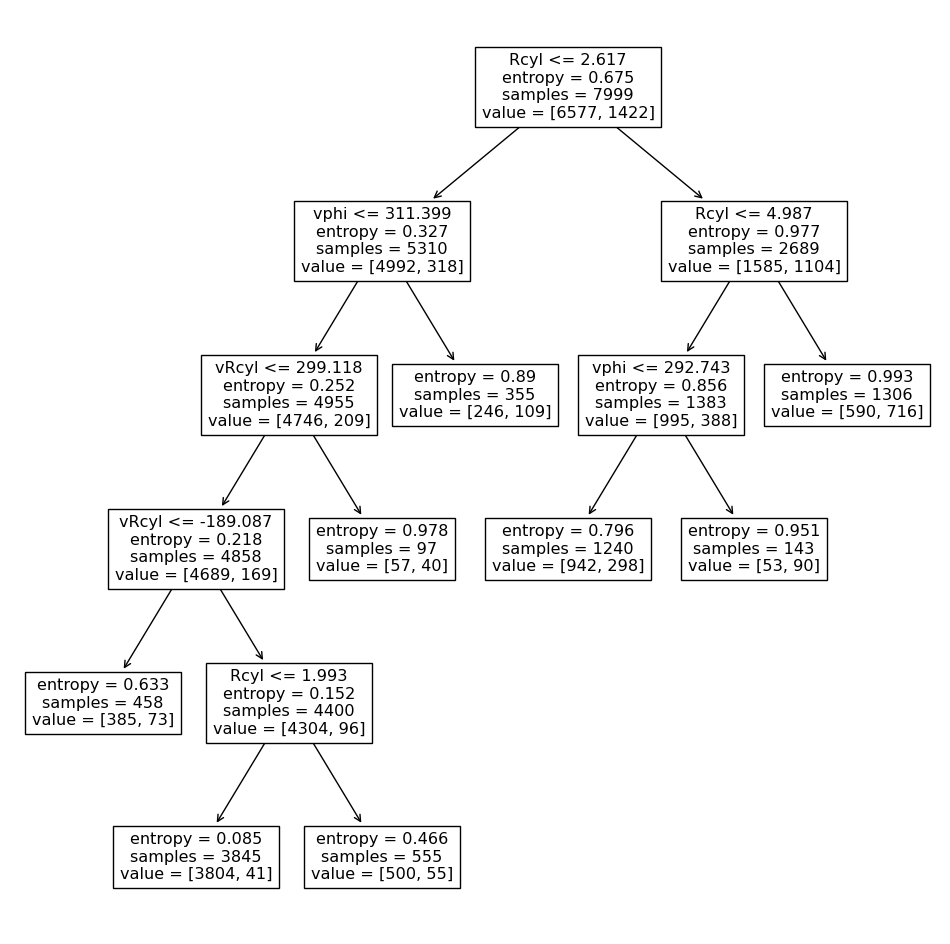

In [166]:
ax = plt.subplots(figsize=(12, 12))[1] 
plot_tree(best_, feature_names=feature_names, ax=ax);
print('Number of leaves:', best_.get_n_leaves())

In [165]:
confusion = confusion_table(best_.predict(x_test), y_test)
confusion

Truth,0,1
Predicted,,
0,1470,164
1,178,188


# Bagging

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_estimators are the number of trees in the forest. 

In [171]:
bag_migrater = RandomForestClassifier(n_estimators=100, max_features = x_train.shape[1], random_state=0, bootstrap=True)
bag_migrater.fit(x_train, y_train)

RandomForestClassifier(max_features=15, random_state=0)

In [174]:
print('Test accuracy using bagging', accuracy_score(y_test, bag_migrater.predict(x_test)))

Test accuracy using bagging 0.868


Importance of different variables. 

In [180]:
feature_imp = pd.DataFrame( {'importance': bag_migrater.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Rcyl,0.318441
vphi,0.140536
vRcyl,0.119667
vz,0.072615
z,0.054823
phi,0.054632
mass,0.049443
age,0.033590
ofe,0.032856
cfe,0.029225


# Random forest

Do the same but vary the max_feauture argument for the RandomForestClassifier. 

In [ ]:
accuracy_list = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=100, max_features = i, random_state=0, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list.append(accuracy)    

In [ ]:
accuracy_list_1 = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=100, max_features = i, random_state=1, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list_1.append(accuracy)    
    
accuracy_list_2 = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=100, max_features = i, random_state=2, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list_2.append(accuracy)    

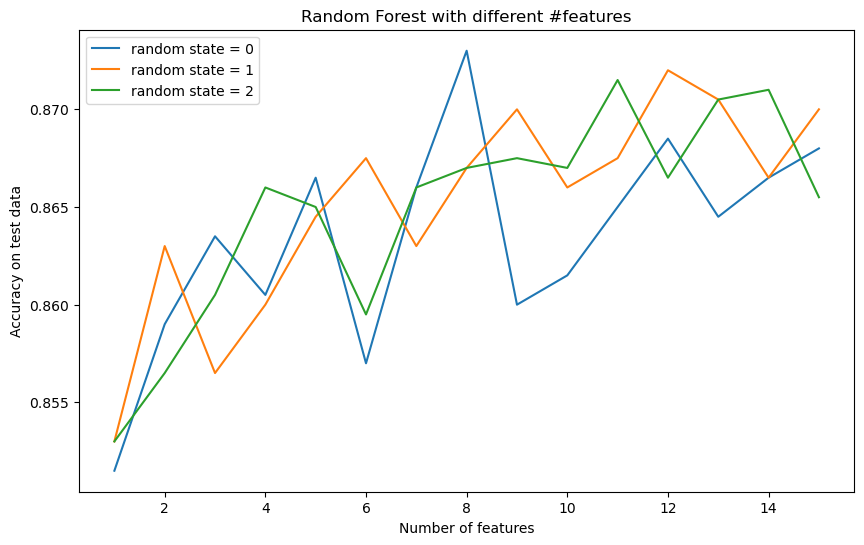

In [194]:
plt.figure(figsize=(10, 6))
plt.xlabel('Number of features')
plt.ylabel('Accuracy on test data')
plt.title('Random Forest with different #features')
plt.plot(range(1, x_train.shape[1] + 1), accuracy_list, label = 'random state = 0')
plt.plot(range(1, x_train.shape[1] + 1), accuracy_list_1, label = 'random state = 1')
plt.plot(range(1, x_train.shape[1] + 1), accuracy_list_2, label = 'random state = 2')
plt.legend();

So we see a small increasing tendency but also that it varies from random state to random state what number of feautes are the best. However we can see that in general they are in between 0.855 and 0.870 which is a pretty small gap. 

# Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

The argument n_estimators=1000 indicates that we want 1000 trees, and the option max_depth=3 limits the depth of each tree. The argument learning_rate is the $\lambda$ (i.e. the shrinkage parameter). 

In [197]:
boost_migrator = GradientBoostingClassifier(n_estimators = 1000, learning_rate=0.01, random_state=0)
boost_migrator.fit(x_train, y_train)
print('Test accuracy using boosting', accuracy_score(y_test, boost_migrator.predict(x_test)))

Test accuracy using boosting 0.874


Lets try different values of the learning_rate.

In [200]:
lambdas = np.linspace(0.05, 0.2, 10)
accuracy_list_boost = []
for i in lambdas: 
    boost_migrator = GradientBoostingClassifier(n_estimators = 1000, learning_rate=i, random_state=0)
    boost_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, boost_migrator.predict(x_test))
    accuracy_list_boost.append(accuracy)

Text(0, 0.5, 'Accuracy on test data')

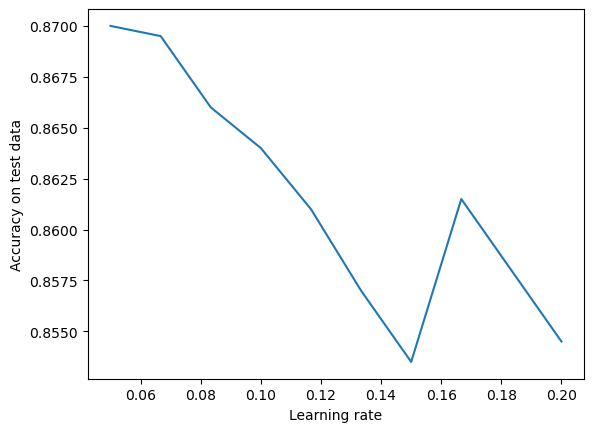

In [201]:
plt.plot(lambdas, accuracy_list_boost, label = 'Gradient Boosting')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy on test data')

Peak is a little weird. Otherwise makes sense that it is best with low values of $\lambda$